In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.tram_data_helpers import *
from scipy.special import logit

Train with GPU support.


# 1. Experiments and Paths

In [ ]:
experiment_name = "tramdagpaper_exp6_1_complexDGP_cs"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/configuration.json


# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

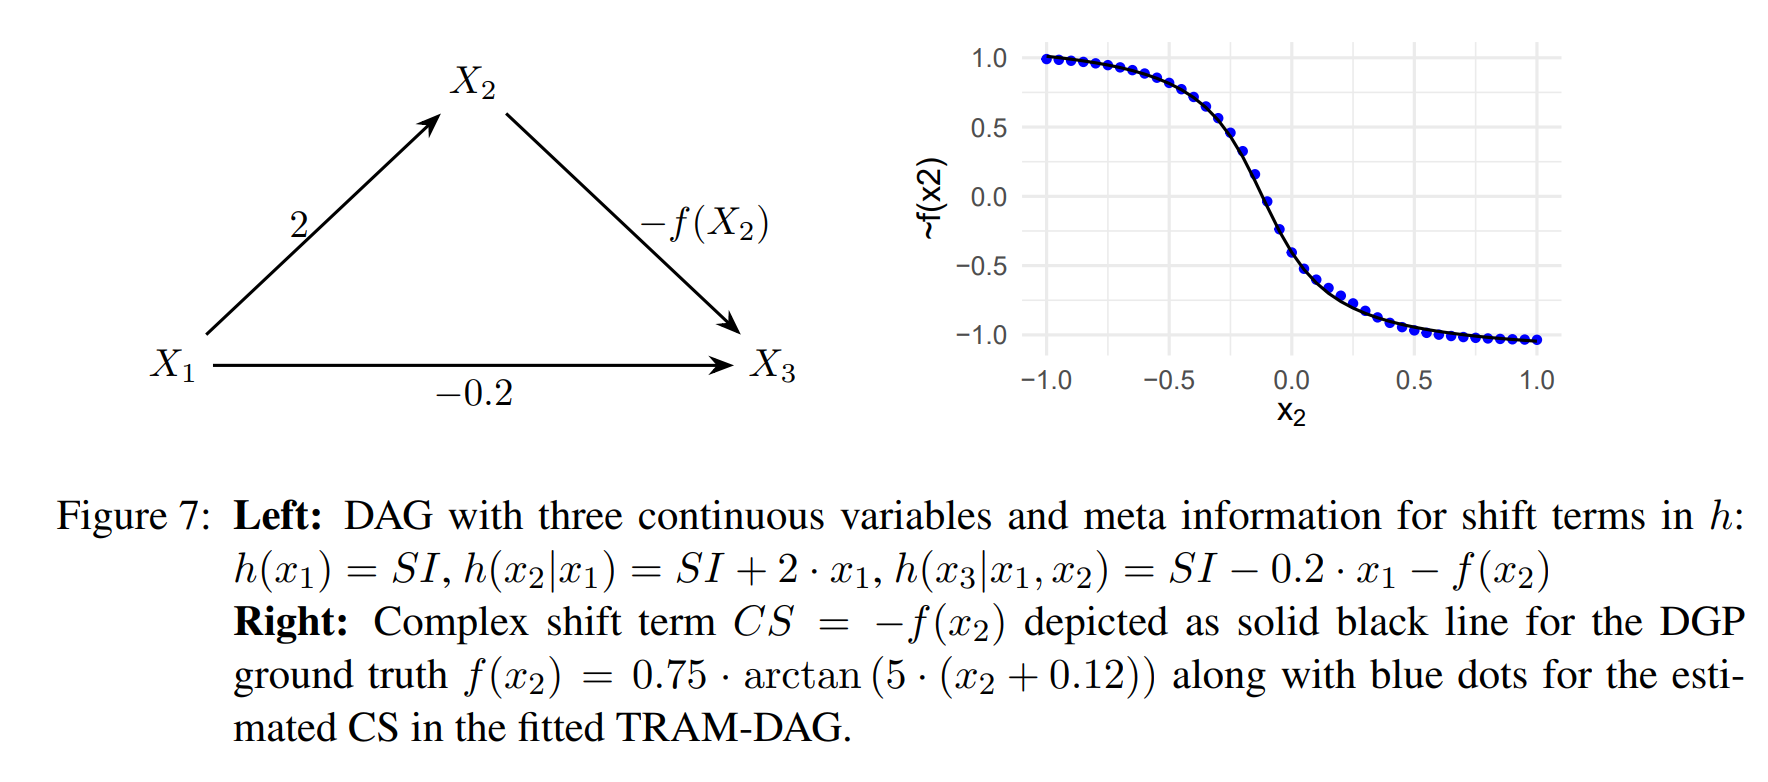

they made 3 experiments:
1. Linear-shift DGP and linear-shift model 
2. Complex-shift DGP and complex-shift model  <------------------
3. Linear-shift DGP and complex-shift model 

Setting Seed: 42
Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/tramdagpaper_exp6_1_complexDGP_cs_new.csv
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


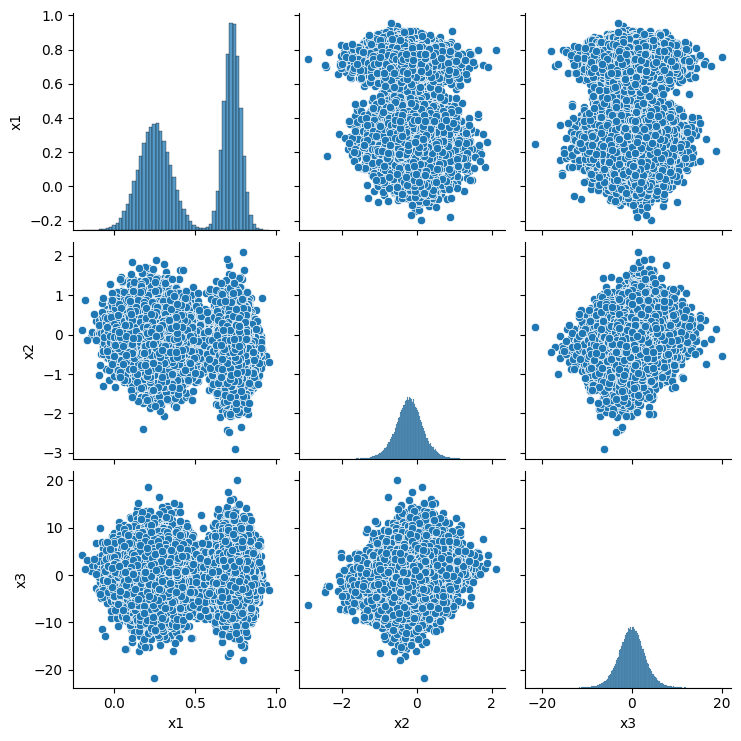

In [19]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return 0.75*np.arctan(5*(x+0.12))  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=10_000

df = dgp(n_obs=n_obs, seed=42)

EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [20]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

train_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_test.csv"), index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 80000, Validation size: 10000, Test size: 10000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/configuration.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


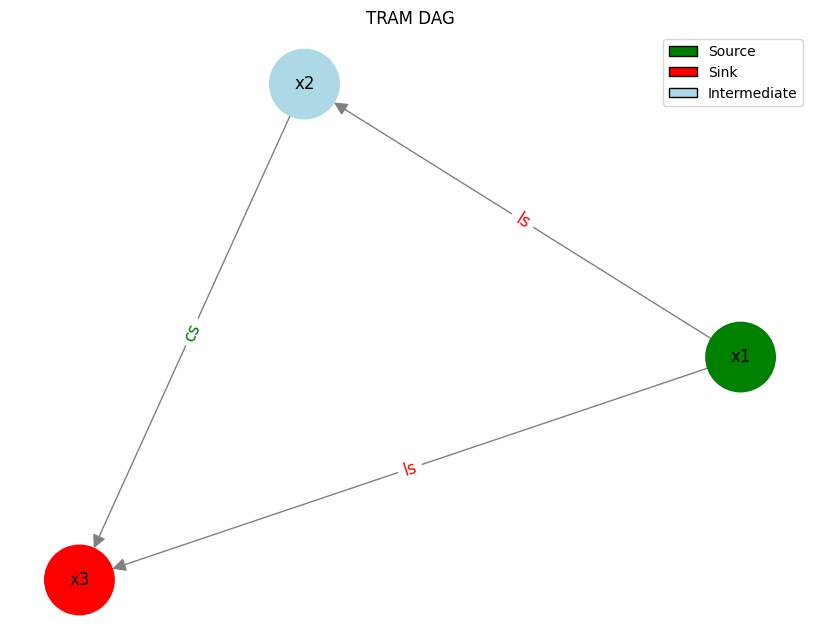

In [21]:

interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

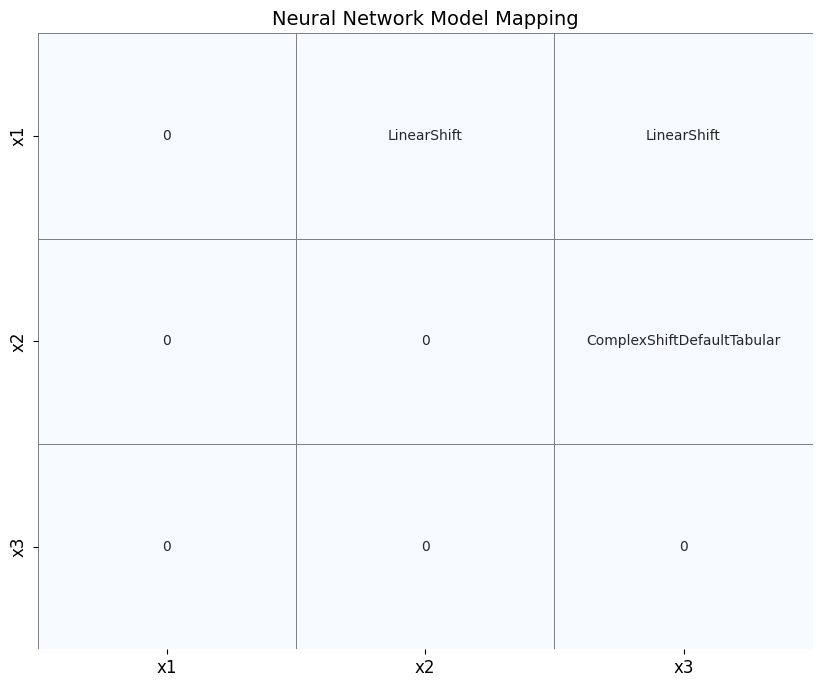

In [22]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [23]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414735, 'max': 0.794303998711493, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('cs')}, 'min': -5.0085370918109335, 'max': 4.899694288782983,

In [24]:
# hyperparams:
train_list=['x1','x2','x3']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
# if you change the hyperparams -> write them to the config file!

In [25]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    # batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 500
    learning_rate = 0.01
    use_scheduler = False
    ###########################################
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")
    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=True)
    
    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, debug=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=True,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=500, learning_rate=0.01, use_scheduler=False

Node x1 not trained yet or training incomplete. Starting from epoch 103.
[DEBUG] R script written to: /tmp/tmpagbb7igg.R
[DEBUG] R code:
 
library(MASS)
library(tram)
library(readr)

data <- read_csv("/home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/tramdagpaper_exp6_1_complexDGP_cs_new_train.csv")
model <- Colr(x1 ~ 1, data=data, order=19)
cat(model$theta, sep="\n")

[DEBUG] Rscript succeeded
[DEBUG] STDOUT:
 -2.246133
-1.745155
-1.057427
-1.057427
-0.7017669
-0.2315873
-0.04547494
-0.04547492
-0.04547491
-0.04547489
-0.04547488
-0.04547486
-0.04547485
-0.04547483
-0.04547482
-0.0454748
-0.04547479
0.3690576
1.216967
2.239766

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=F

/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 104/500  Train NLL: -0.5742  Val NLL: -0.5782  [Train: 2.01s  Val: 0.35s  Total: 2.36s]
Saved new best model.
Epoch 105/500  Train NLL: -0.5741  Val NLL: -0.5782  [Train: 2.31s  Val: 0.38s  Total: 2.69s]
Epoch 106/500  Train NLL: -0.5737  Val NLL: -0.5782  [Train: 2.42s  Val: 0.38s  Total: 2.80s]
Epoch 107/500  Train NLL: -0.5742  Val NLL: -0.5782  [Train: 2.36s  Val: 0.38s  Total: 2.75s]
Saved new best model.
Epoch 108/500  Train NLL: -0.5739  Val NLL: -0.5782  [Train: 2.02s  Val: 0.40s  Total: 2.42s]
Epoch 109/500  Train NLL: -0.5740  Val NLL: -0.5782  [Train: 1.79s  Val: 0.36s  Total: 2.15s]
Saved new best model.
Epoch 110/500  Train NLL: -0.5744  Val NLL: -0.5783  [Train: 2.38s  Val: 0.37s  Total: 2.76s]
Saved new best model.
Epoch 111/500  Train NLL: -0.5743  Val NLL: -0.5783  [Train: 2.43s  Val: 0.36s  Total: 2.79s]
Saved new best model.
Epoch 112/500  Train NLL: -0.5738  Val NLL: -0.5783  [Train: 2.15s  Val: 0.38s  Total: 2.54s]
Epoch 113/500  Train N

/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 2.6259  Val NLL: 2.2260  [Train: 2.59s  Val: 0.37s  Total: 2.97s]
Saved new best model.
Epoch 2/500  Train NLL: 1.9567  Val NLL: 1.7133  [Train: 2.30s  Val: 0.41s  Total: 2.72s]
Saved new best model.
Epoch 3/500  Train NLL: 1.4923  Val NLL: 1.2884  [Train: 2.54s  Val: 0.40s  Total: 2.95s]
Saved new best model.
Epoch 4/500  Train NLL: 1.1567  Val NLL: 1.0431  [Train: 2.56s  Val: 0.42s  Total: 2.98s]
Saved new best model.
Epoch 5/500  Train NLL: 0.9130  Val NLL: 0.8020  [Train: 2.53s  Val: 0.49s  Total: 3.02s]
Saved new best model.
Epoch 6/500  Train NLL: 0.7478  Val NLL: 0.7018  [Train: 2.48s  Val: 0.39s  Total: 2.87s]
Saved new best model.
Epoch 7/500  Train NLL: 0.6747  Val NLL: 0.6471  [Train: 2.32s  Val: 0.40s  Total: 2.72s]
Saved new best model.
Epoch 8/500  Train NLL: 0.6313  Val NLL: 0.6110  [Train: 2.47s  Val: 0.40s  Total: 2.88s]
Saved new best model.
Epoch 9/500  Train NLL: 0.6004  Val NLL: 0.5847  [Train: 2.26s  Val: 0.39s  Total:

/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 4.7016  Val NLL: 4.3070  [Train: 3.05s  Val: 0.51s  Total: 3.57s]
Saved new best model.
Epoch 2/500  Train NLL: 4.0223  Val NLL: 3.7540  [Train: 3.21s  Val: 0.42s  Total: 3.64s]
Saved new best model.
Epoch 3/500  Train NLL: 3.5247  Val NLL: 3.3294  [Train: 3.23s  Val: 0.50s  Total: 3.74s]
Saved new best model.
Epoch 4/500  Train NLL: 3.2018  Val NLL: 3.0993  [Train: 3.13s  Val: 0.45s  Total: 3.59s]
Saved new best model.
Epoch 5/500  Train NLL: 2.9816  Val NLL: 2.8776  [Train: 3.40s  Val: 0.46s  Total: 3.88s]
Saved new best model.
Epoch 6/500  Train NLL: 2.8121  Val NLL: 2.7552  [Train: 3.20s  Val: 0.45s  Total: 3.66s]
Saved new best model.
Epoch 7/500  Train NLL: 2.7161  Val NLL: 2.6775  [Train: 3.50s  Val: 0.47s  Total: 3.98s]
Saved new best model.
Epoch 8/500  Train NLL: 2.6504  Val NLL: 2.6220  [Train: 3.14s  Val: 0.45s  Total: 3.60s]
Saved new best model.
Epoch 9/500  Train NLL: 2.6027  Val NLL: 2.5810  [Train: 3.01s  Val: 0.43s  Total:

# 6 Inspect Training

## 6.1 Loss vs epochs

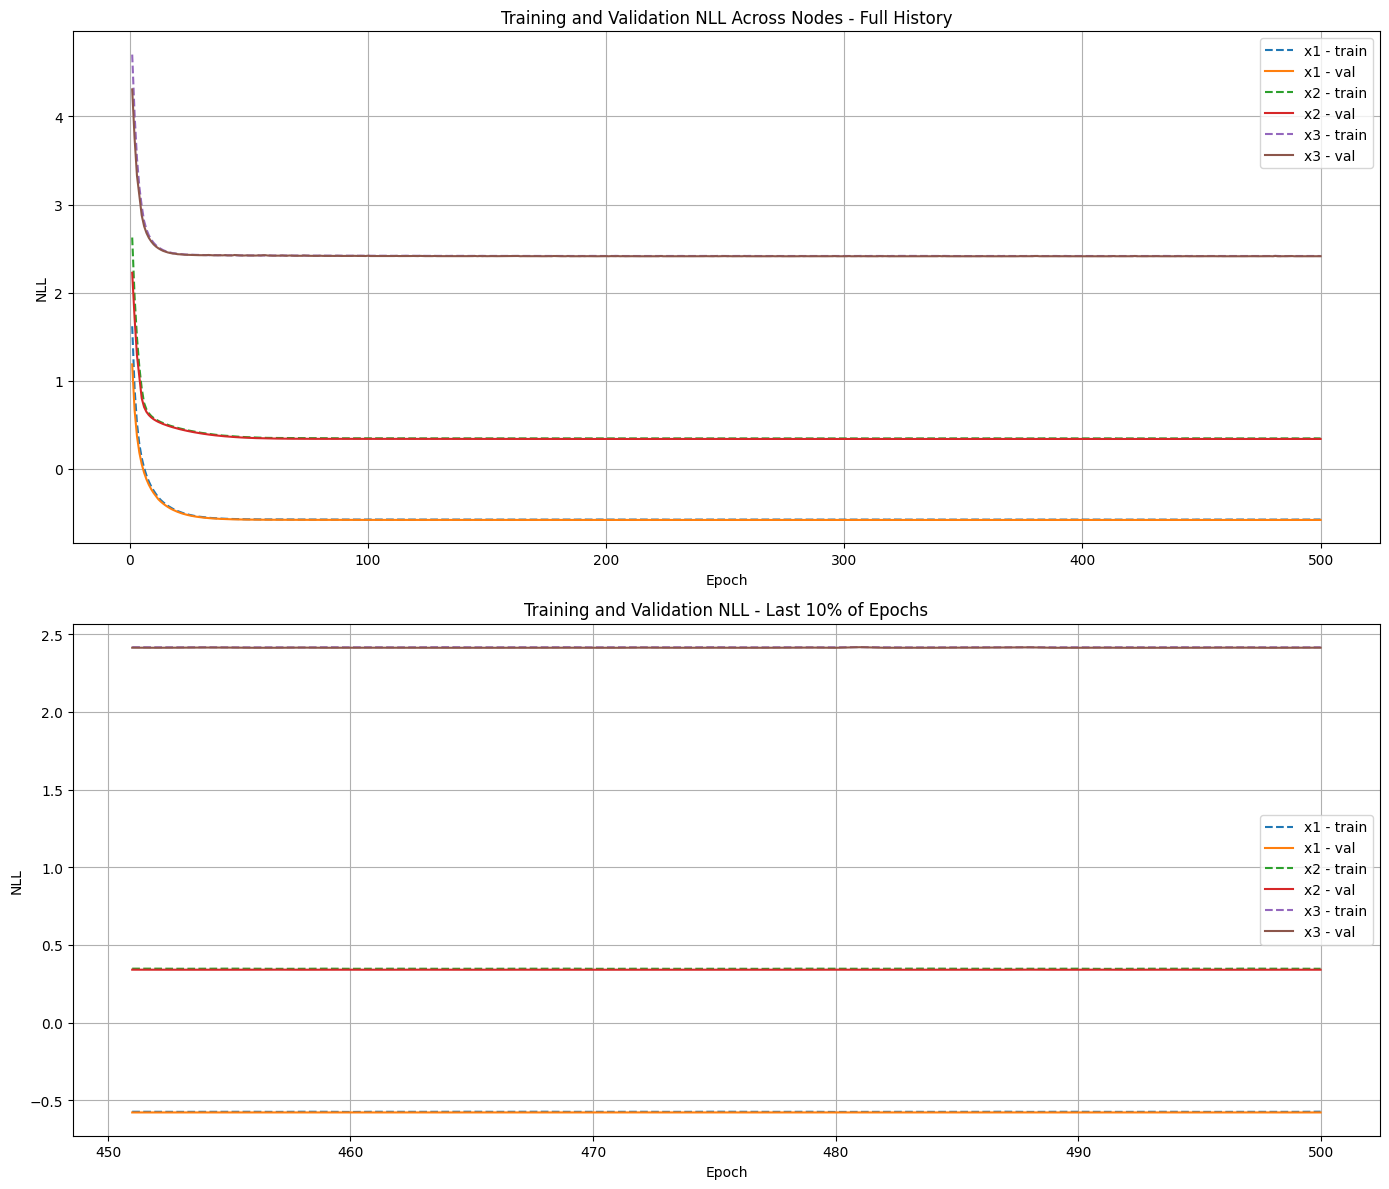

In [31]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


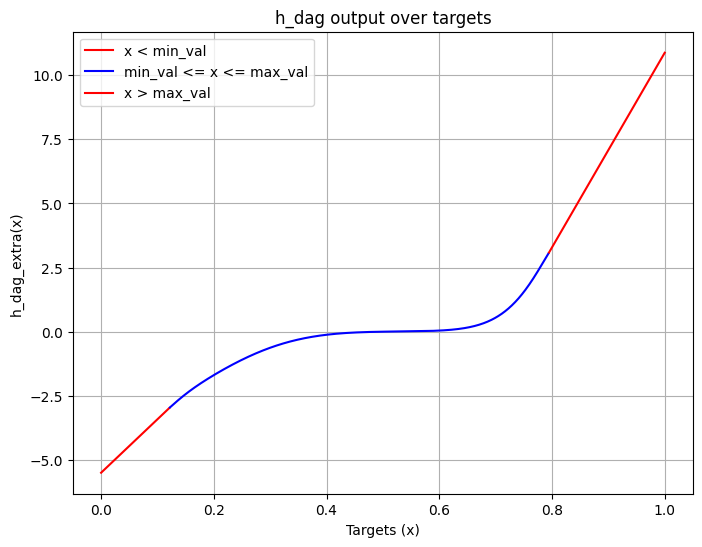

In [32]:
show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


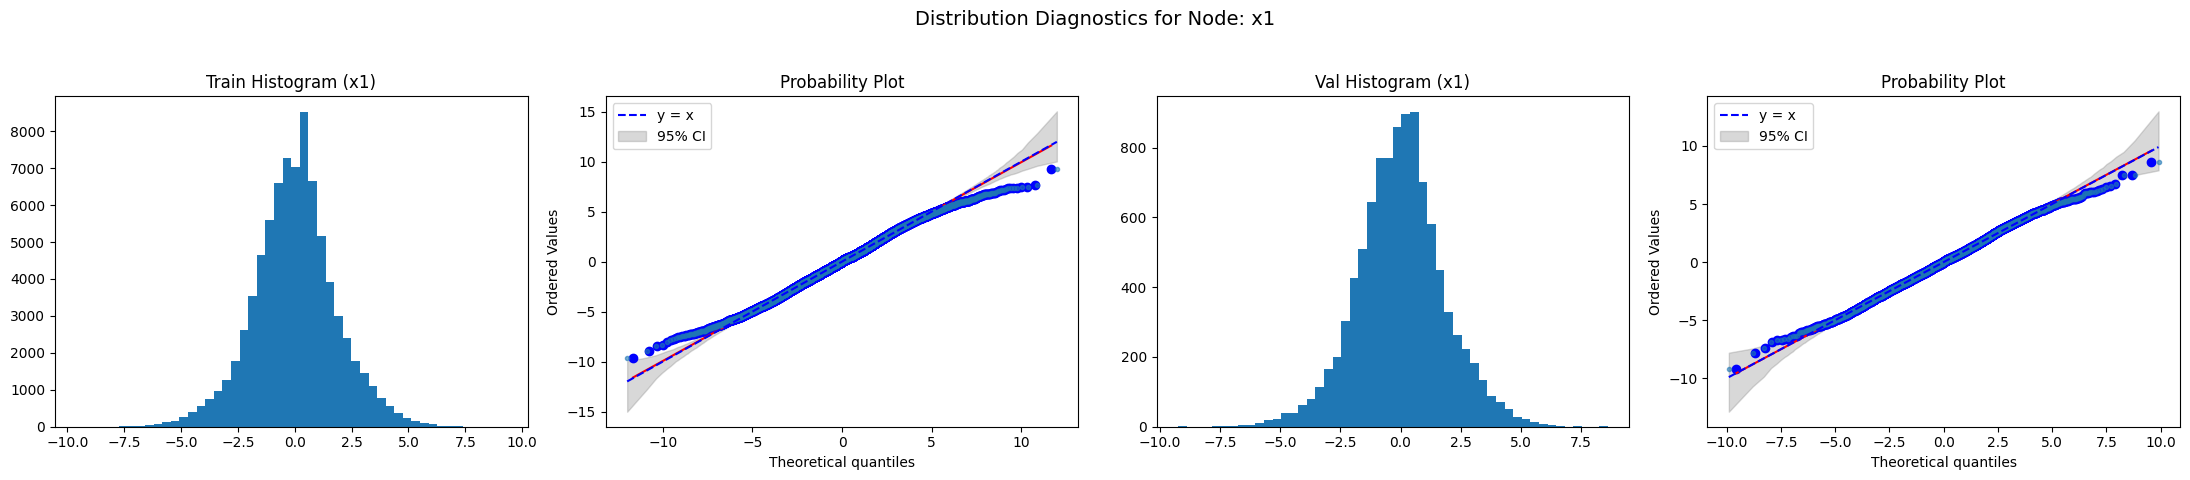

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


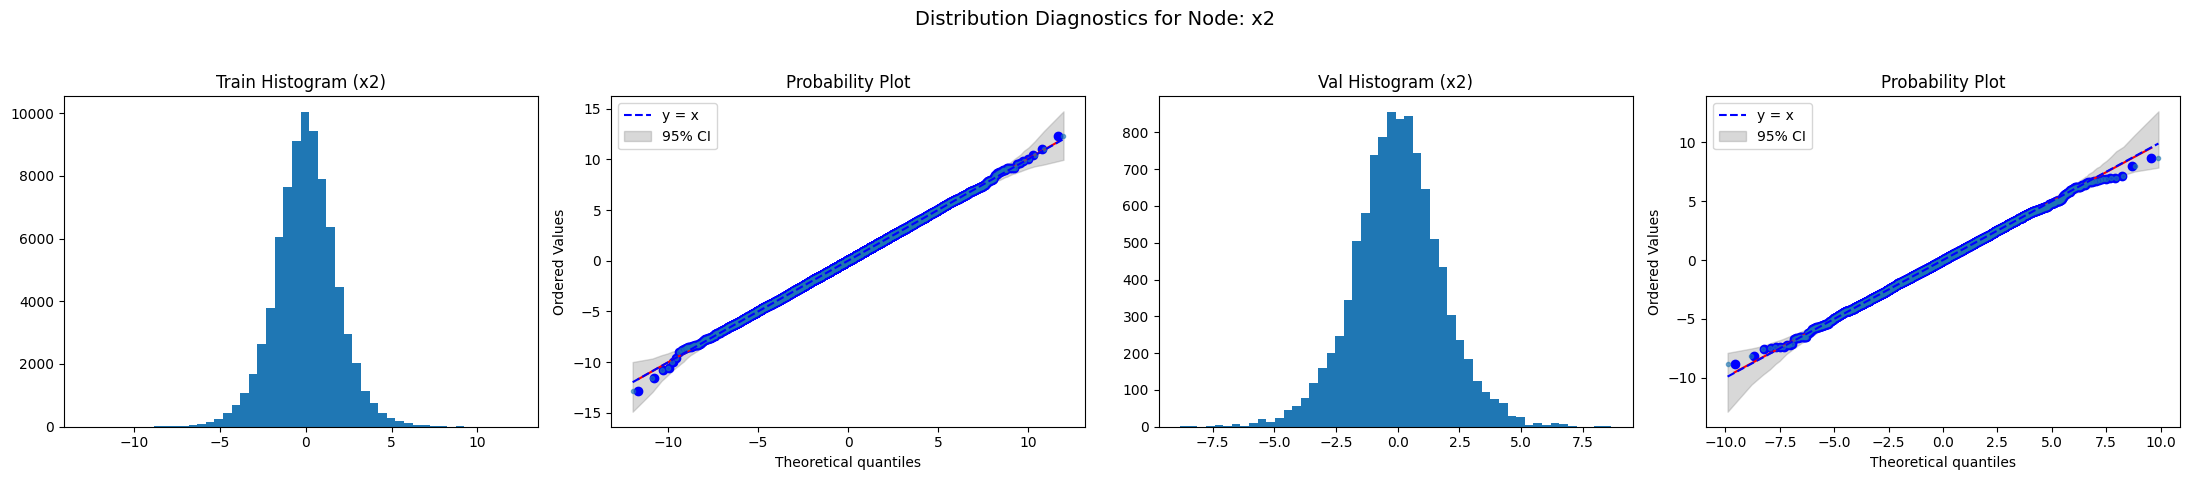

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


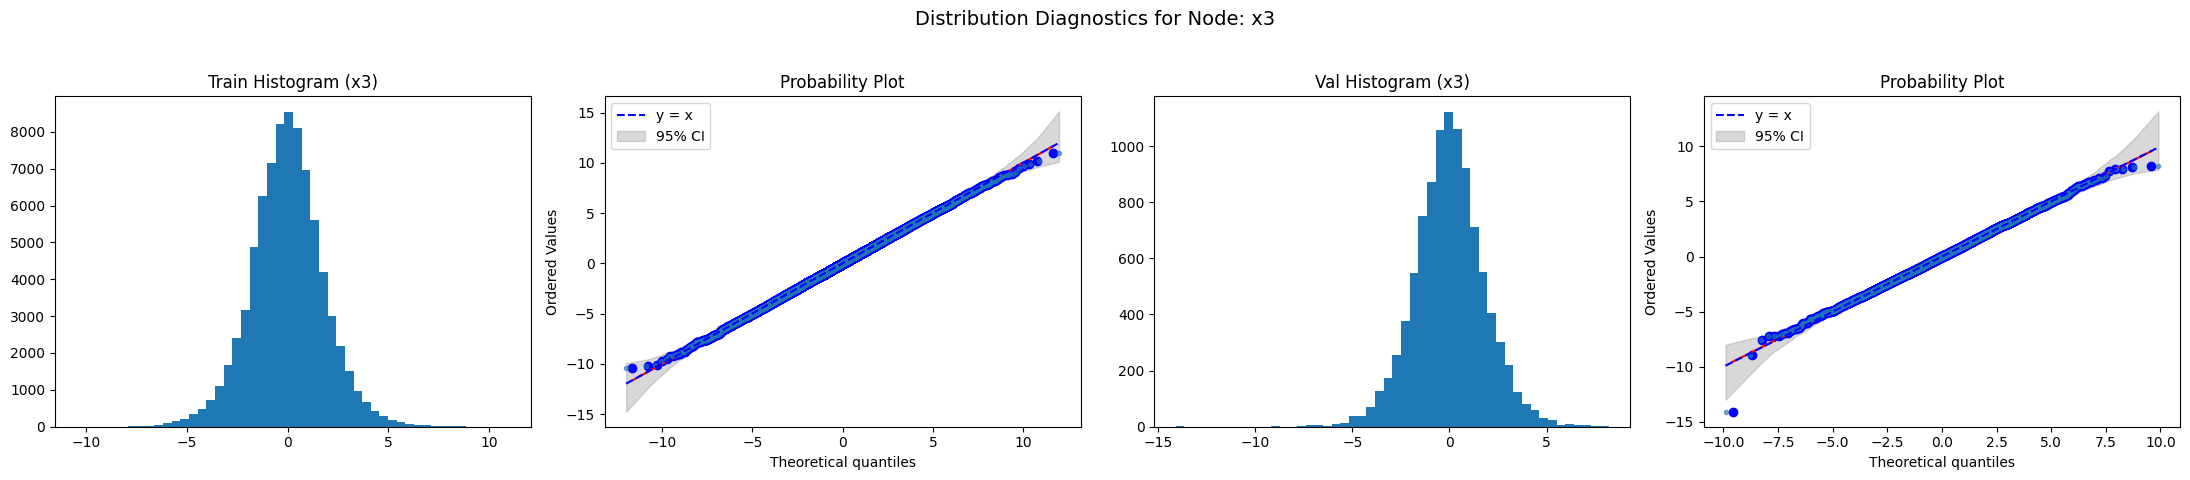

(array([[ 0.6912163 , -0.7541295 , -0.21333265],
        [-4.068815  ,  2.674954  ,  0.17435241],
        [ 1.250442  ,  1.2067063 , -0.6711824 ],
        ...,
        [ 0.3856683 ,  0.33263767,  0.82754254],
        [ 1.1020712 ,  4.5708504 , -0.43443513],
        [-2.663317  , -1.9557755 , -1.2228994 ]], dtype=float32),
 array([[ 3.6791458 , -3.3483055 ,  1.1771014 ],
        [-1.21126   ,  2.0250382 , -0.32996535],
        [ 1.4229817 ,  0.02797532,  2.8806548 ],
        ...,
        [-1.1560249 ,  1.3647211 , -0.15784264],
        [ 0.30909237,  1.5665778 , -1.8957617 ],
        [ 0.01442054,  1.194718  ,  0.25921416]], dtype=float32))

In [33]:
inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


----*----------*-------------*--------check LS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check LS of x2 ------------*-----------------*-------------------*--


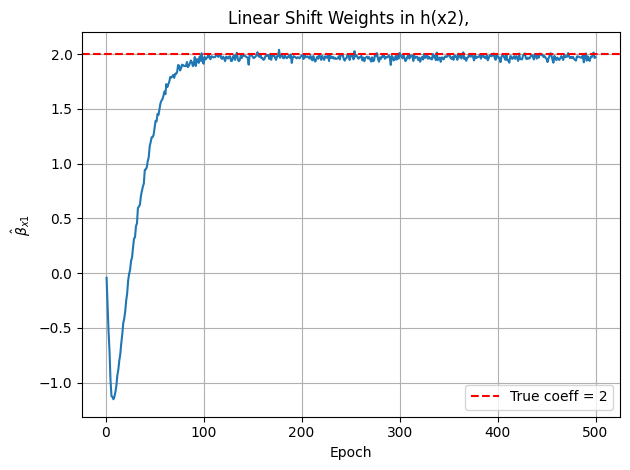


----*----------*-------------*--------check LS of x3 ------------*-----------------*-------------------*--


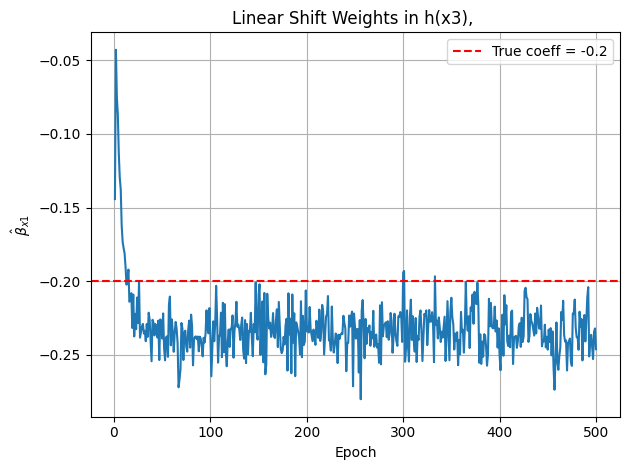

In [34]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in node_list:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if node_list[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        
        if node=='x3':
            shift_name = f"shift_{1}"
        else:
            shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{node_list[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : source, not supported yet.

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
Module 0 (LinearShift) weights:
tensor([[1.9801]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
Module 0 (ComplexShiftDefaultTabular) predictions:
Module 1 (LinearShift) weights:
tensor([[-0.2267]], device='cuda:0')


/tmp/ipykernel_1651561/3637850901.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")


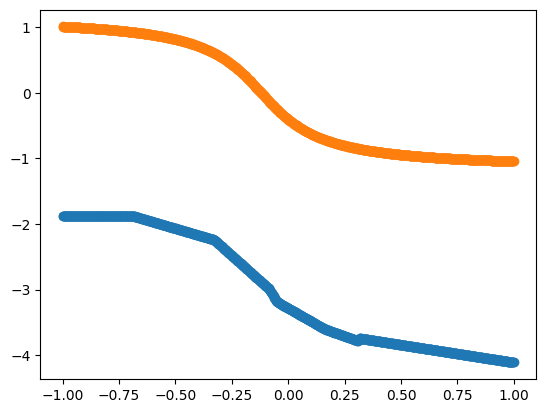

In [38]:

verbose = False
batch_size = 4112

x = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (100, 1)


def f(x):
    return 0.75*np.arctan(5*(x+0.12))  
for node in node_list:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')

    if node_list[node]['node_type'] == 'source':
        print("Node type : source, not supported yet.")
        continue

    # Load model
    NODE_DIR = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")

    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=False)
    tram_model.load_state_dict(torch.load(model_path, map_location=device))
    tram_model.to(device)   # <--- Move model to device
    tram_model.eval()
    
    for i, module in enumerate(tram_model.nn_shift):
        module_name = module.__class__.__name__
        if module_name == 'LinearShift':
            print(f"Module {i} ({module_name}) weights:")
            print(module.fc.weight.data)
        else:
            print(f"Module {i} ({module_name}) predictions:")
            with torch.no_grad():
                y = module(x)
plt.scatter(x.cpu().numpy(),y.cpu().numpy())
plt.scatter(x.cpu().numpy(),-f(x.cpu().numpy()),cmap="red")
plt.show()


# 7. Sample from Graph

In [39]:
sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={},
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)   

[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 328.87it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 324.56it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 317.97it/s]

[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


({'x1': tensor([0.6766, 0.6975, 0.3179,  ..., 0.2644, 0.2534, 0.2224]),
  'x2': tensor([-0.0806, -0.6212,  0.0648,  ..., -0.4705,  0.4047, -0.0458]),
  'x3': tensor([-2.2087,  4.6964,  3.1884,  ..., -1.4293,  3.4561,  3.5590])},
 {'x1': tensor([ 0.3131,  0.5162, -0.4960,  ..., -0.9473, -1.0597, -1.4120]),
  'x2': tensor([ 1.1845, -2.2620,  0.6055,  ..., -1.5409,  3.4096,  0.6477]),
  'x3': tensor([-0.4348,  3.6357,  2.0443,  ...,  0.0802,  1.3066,  3.2539])})

## 7.3 Inspect Sampling

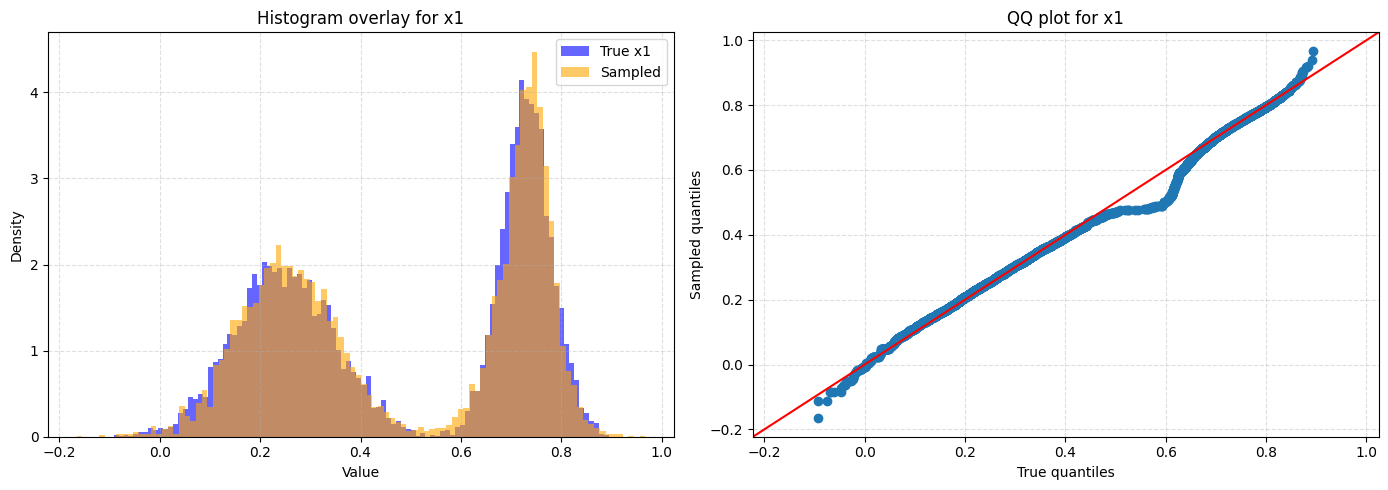

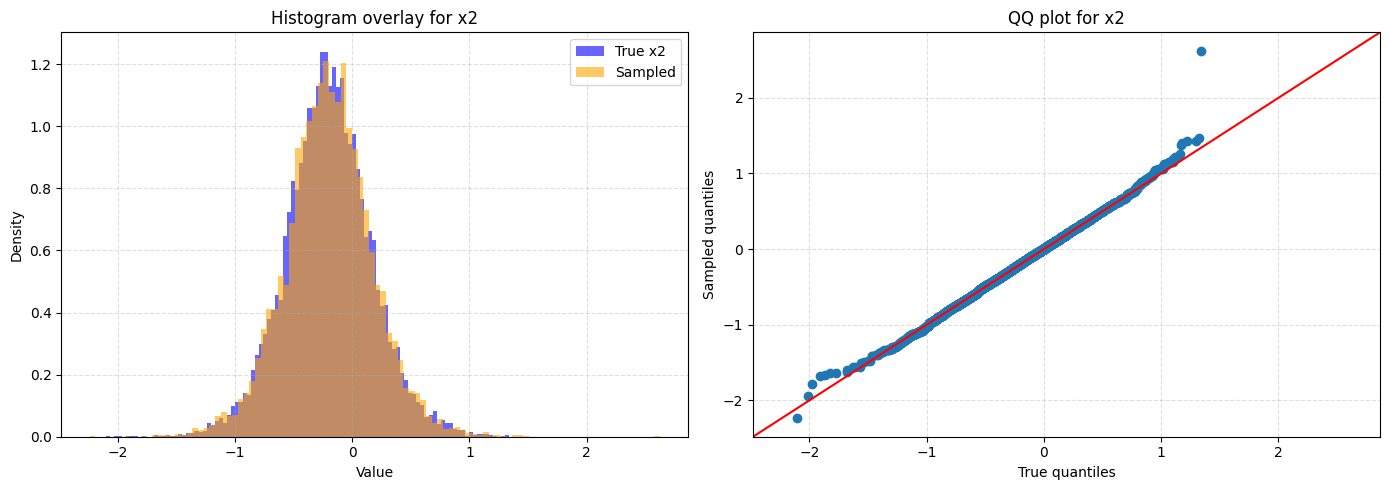

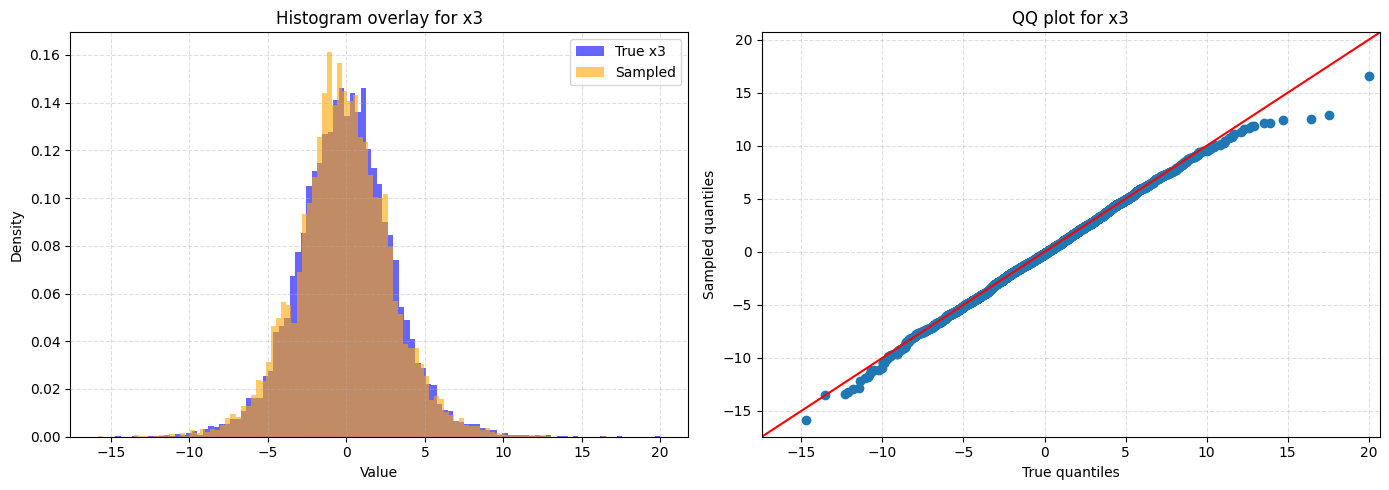

In [40]:
show_samples_vs_true(test_df,node_list,EXPERIMENT_DIR)

## 7.4 Intervention

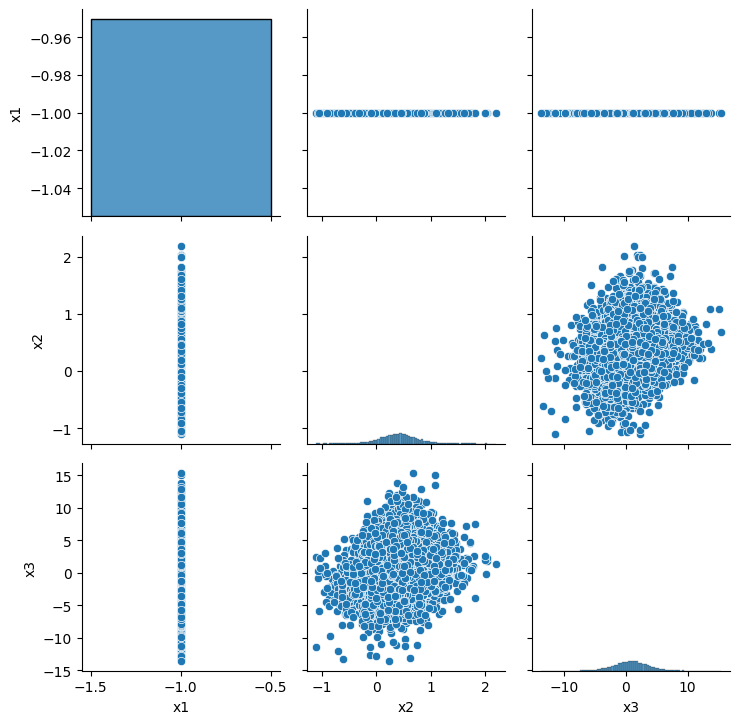

In [41]:
def f(x):
    return 0.75*np.arctan(5*(x+0.12))  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [42]:
sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={'x1':-1.0},
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)  

[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_complexDGP_cs_new/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x1' with value -1.0
Interventional data for node x1 is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 324.14it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 326.81it/s]

[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


({'x1': tensor([-1., -1., -1.,  ..., -1., -1., -1.]),
  'x2': tensor([0.3151, 0.1342, 0.2646,  ..., 0.1114, 0.3455, 0.5574]),
  'x3': tensor([ 2.3186,  1.6657,  3.3215,  ..., -0.4916,  2.8112,  3.3728])},
 {'x1': tensor([nan, nan, nan,  ..., nan, nan, nan]),
  'x2': tensor([-0.3941, -1.2707, -0.6265,  ..., -1.3900, -0.2444,  0.8510]),
  'x3': tensor([ 1.5562,  0.0939,  1.2522,  ..., -0.7708,  0.3417,  1.7107])})

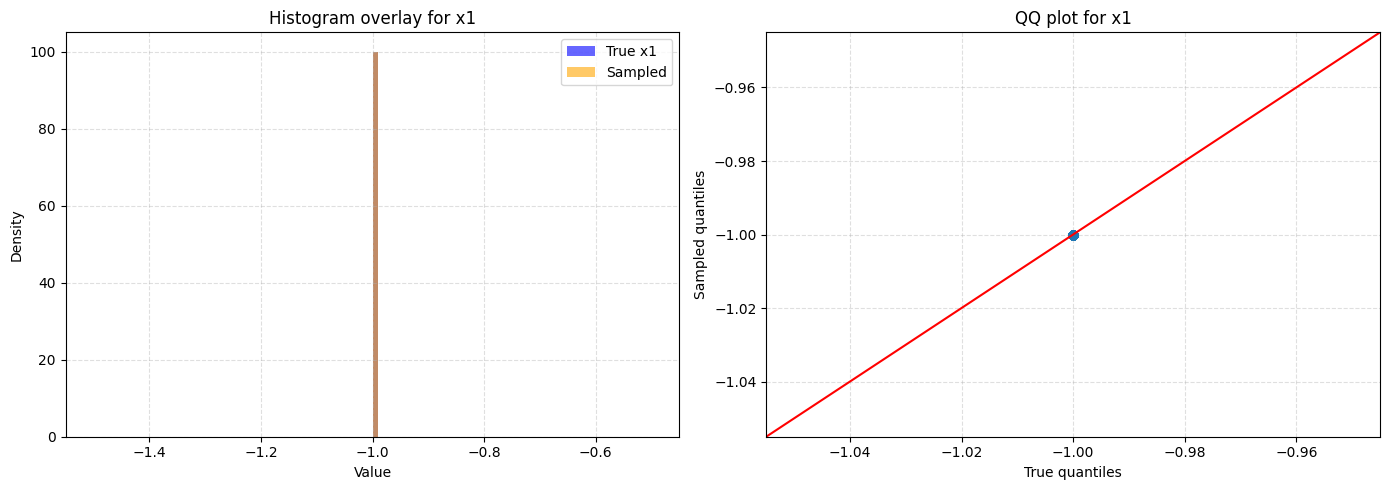

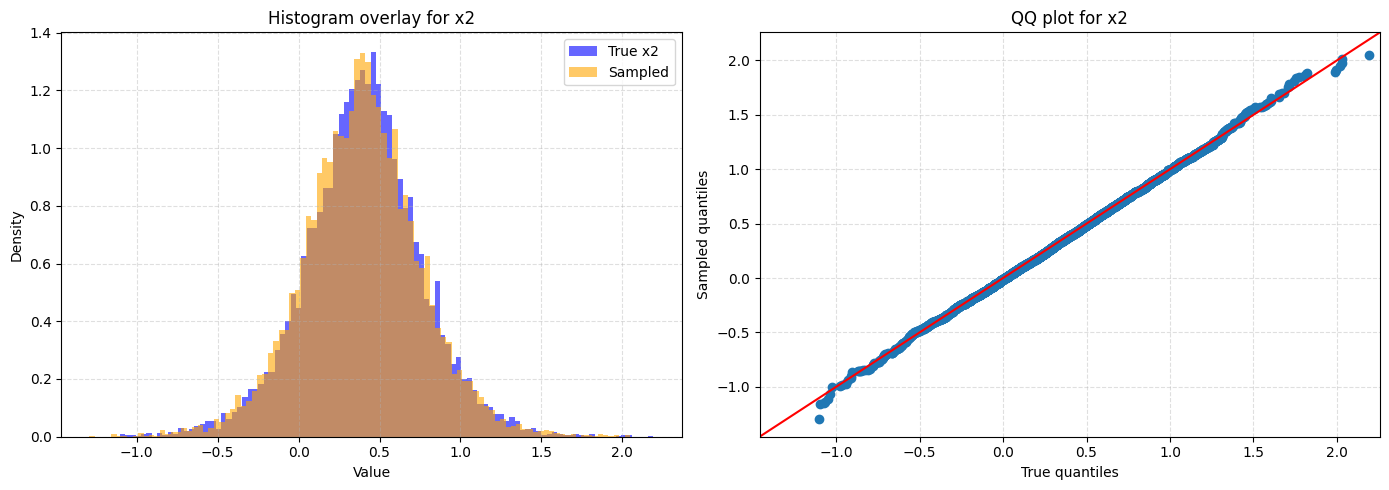

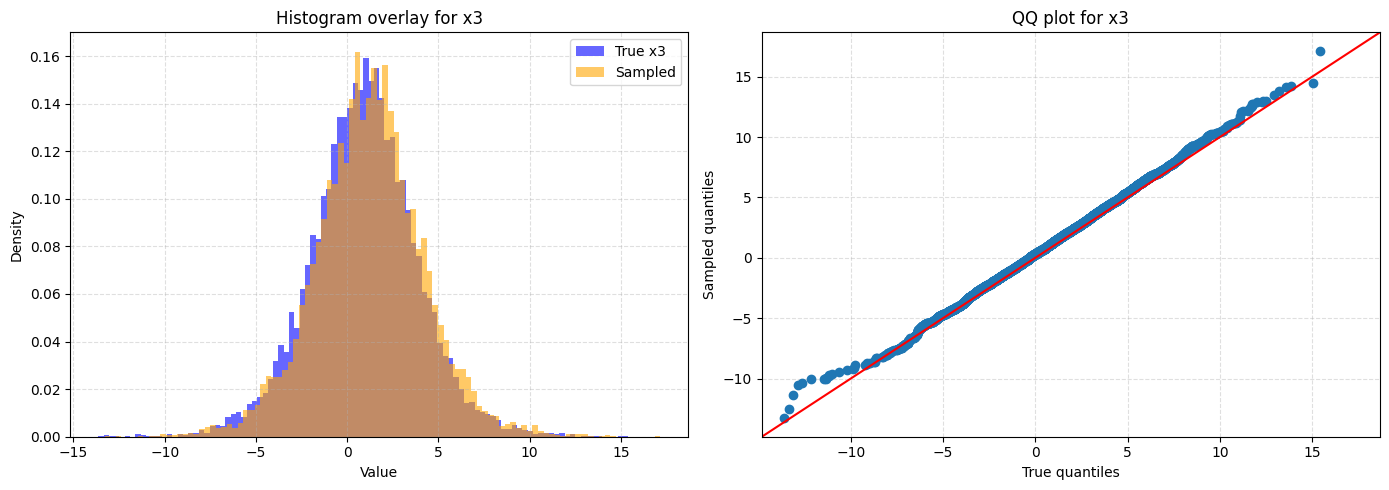

In [43]:
show_samples_vs_true(intervention_df,node_list,EXPERIMENT_DIR)